## Bikeshare: Assignment Description

**Difficulty Level:** Intermediate
**Target Column:** count

**Description:** This dataset counts hourly bike rentals throughout a city over the course of 2 years.  It contains around 10,000 samples that logs information about the weather at that point in time, as well as the date.  It's meant to be a lightweight time series that gives people practice in encoding time based variables, but without the messiness of the `restaurants` data set.

**Questions that could be answered by this dataset:** How do time based characteristics like time of day and previously occurring trends impact the ability to forecast total rentals?  What about weather?  This dataset is primarily about being able to accurately capture the impact of time on your target variable.  A good choice for people who want to continue on the forecasting path, but want a change of pace from the data covered in class so far.

**Challenges that come with this dataset:** Success on this dataset heavily relies on capturing the passage of time.  Doing this correctly will give you good results, if you miss the key points your model will punch well below its weight.  The dataset is also setup in a slightly unusual way:  it only includes days 1-18 of the month, so if you are using shift statistics it's important to make note of this.

**Outside sources for this dataset:** This dataset is listed on kaggle, and has many active notebooks, which you can find here:  https://www.kaggle.com/c/bike-sharing-demand


## Business Problem

- Can we predict bike rentals, based on features like weather, season, time of day?
- A solution like this may be used to inform staffing, or inventory at any given point in time to avoid excess
- This is a supervised learning problem, because we have data with an answer (count of rentals)
- How to measure performance? Perhaps MSE. At the very least, this should perform better than the baseline, which would be to look at the mean of count. 

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


In [2]:
# load data
bikes = pd.read_csv('data/bikeshare.csv', parse_dates=True)

In [3]:
# make a copy of the dataset
bikes_df = bikes.copy()

In [4]:
# examine data
bikes_df.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,Spring,0,0,Clear Skies,9.84,14.395,81,0.0000,16
1,2011-01-01 01:00:00,Spring,0,0,Clear Skies,9.02,13.635,80,0.0000,40
2,2011-01-01 02:00:00,Spring,0,0,Clear Skies,9.02,13.635,80,0.0000,32
3,2011-01-01 03:00:00,Spring,0,0,Clear Skies,9.84,14.395,75,0.0000,13
4,2011-01-01 04:00:00,Spring,0,0,Clear Skies,9.84,14.395,75,0.0000,1
5,2011-01-01 05:00:00,Spring,0,0,Partly Cloudy,9.84,12.880,75,6.0032,1
6,2011-01-01 06:00:00,Spring,0,0,Clear Skies,9.02,13.635,80,0.0000,2
7,2011-01-01 07:00:00,Spring,0,0,Clear Skies,8.20,12.880,86,0.0000,3
8,2011-01-01 08:00:00,Spring,0,0,Clear Skies,9.84,14.395,75,0.0000,8
9,2011-01-01 09:00:00,Spring,0,0,Clear Skies,13.12,17.425,76,0.0000,14


will need to encode:
- datetime
- season
- weather


In [5]:
# this would be the baseline
bikes_df['count'].mean()

191.57413191254824

In [6]:
bikes_df['count'].median()

145.0

In [7]:
bikes_df['count'].min()

1

In [8]:
bikes_df['count'].max()

977

In [9]:
# check data
bikes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  object 
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  object 
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   count       10886 non-null  int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 850.6+ KB


### Date Things - Add New Datetime Features

In [10]:
# fix datetime
bikes_df['datetime'] = pd.to_datetime(bikes_df['datetime'])

In [11]:
bikes_df['time'] = bikes_df['datetime'].dt.time
bikes_df['hour'] = bikes_df['datetime'].dt.hour
bikes_df['month']= bikes_df['datetime'].dt.month
bikes_df['weekday']= bikes_df['datetime'].dt.weekday

In [12]:
bikes_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,time,hour,month,weekday
0,2011-01-01 00:00:00,Spring,0,0,Clear Skies,9.84,14.395,81,0.0,16,00:00:00,0,1,5
1,2011-01-01 01:00:00,Spring,0,0,Clear Skies,9.02,13.635,80,0.0,40,01:00:00,1,1,5
2,2011-01-01 02:00:00,Spring,0,0,Clear Skies,9.02,13.635,80,0.0,32,02:00:00,2,1,5
3,2011-01-01 03:00:00,Spring,0,0,Clear Skies,9.84,14.395,75,0.0,13,03:00:00,3,1,5
4,2011-01-01 04:00:00,Spring,0,0,Clear Skies,9.84,14.395,75,0.0,1,04:00:00,4,1,5


In [13]:
# summarize data set
bikes_df.describe()

,holiday,workingday,temp,atemp,humidity,windspeed,count,hour,month,weekday
count,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,0.028569,0.680875,20.23086,23.655084,61.886460,12.799395,191.574132,11.541613,6.521495,3.013963
std,0.166599,0.466159,7.79159,8.474601,19.245033,8.164537,181.144454,6.915838,3.444373,2.004585
min,0.000000,0.000000,0.82000,0.760000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,13.94000,16.665000,47.000000,7.001500,42.000000,6.000000,4.000000,1.000000
50%,0.000000,1.000000,20.50000,24.240000,62.000000,12.998000,145.000000,12.000000,7.000000,3.000000
75%,0.000000,1.000000,26.24000,31.060000,77.000000,16.997900,284.000000,18.000000,10.000000,5.000000
max,1.000000,1.000000,41.00000,45.455000,100.000000,56.996900,977.000000,23.000000,12.000000,6.000000


In [14]:
# check for duplicates
# no dupes, yay!
bikes_df[bikes_df.duplicated() == True]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,time,hour,month,weekday


In [15]:
# look for nulls
# no nulls, yay!
bikes_df.isnull().sum()


datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
count         0
time          0
hour          0
month         0
weekday       0
dtype: int64

### Check for outliers- examine features
- temp
- atemp
- windspeed
- humidity

### temp

/Users/hannah.westberg/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


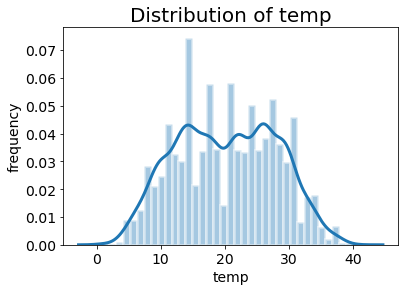

In [16]:

# histogram of temp
ax = sns.distplot(bikes_df.temp, hist=True, hist_kws={"edgecolor": 'w', "linewidth": 3}, kde_kws={"linewidth": 3})

# notation indicating a possible outlier
ax.annotate('Possible outlier', xy=(188,0.0030), xytext=(189,0.0070), fontsize=12,
            arrowprops=dict(arrowstyle='->', ec='grey', lw=2), bbox = dict(boxstyle="round", fc="0.8"))

# ticks 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# labels and title
plt.xlabel('temp', fontsize=14)
plt.ylabel('frequency', fontsize=14)
plt.title('Distribution of temp', fontsize=20);

/Users/hannah.westberg/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of temp')

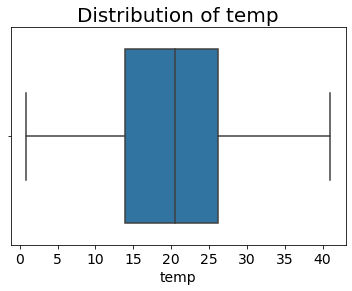

In [17]:
# box plot of the variable temp
ax = sns.boxplot(bikes_df.temp)

# notation indicating an outlier
ax.annotate('Outlier', xy=(190,0), xytext=(186,-0.05), fontsize=14,
            arrowprops=dict(arrowstyle='->', ec='grey', lw=2), bbox = dict(boxstyle="round", fc="0.8"))

# xtick, label, and title
plt.xticks(fontsize=14)
plt.xlabel('temp', fontsize=14)
plt.title('Distribution of temp', fontsize=20)

### humidity

/Users/hannah.westberg/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


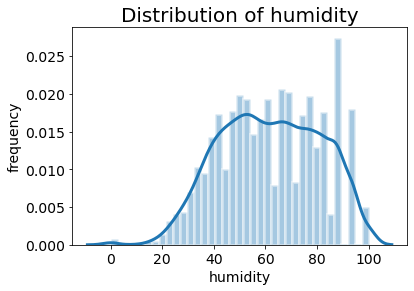

In [18]:
# histogram of humidity
ax = sns.distplot(bikes_df.humidity, hist=True, hist_kws={"edgecolor": 'w', "linewidth": 3}, kde_kws={"linewidth": 3})

# notation indicating a possible outlier
ax.annotate('Possible outlier', xy=(188,0.0030), xytext=(189,0.0070), fontsize=12,
            arrowprops=dict(arrowstyle='->', ec='grey', lw=2), bbox = dict(boxstyle="round", fc="0.8"))

# ticks 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# labels and title
plt.xlabel('humidity', fontsize=14)
plt.ylabel('frequency', fontsize=14)
plt.title('Distribution of humidity', fontsize=20);

/Users/hannah.westberg/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of humidity')

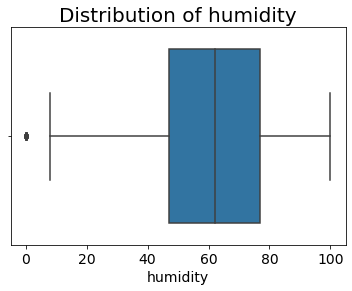

In [19]:
# box plot of the variable temp
ax = sns.boxplot(bikes_df.humidity)

# notation indicating an outlier
ax.annotate('Outlier', xy=(190,0), xytext=(186,-0.05), fontsize=14,
            arrowprops=dict(arrowstyle='->', ec='grey', lw=2), bbox = dict(boxstyle="round", fc="0.8"))

# xtick, label, and title
plt.xticks(fontsize=14)
plt.xlabel('humidity', fontsize=14)
plt.title('Distribution of humidity', fontsize=20)

- looks like one outlier on humidity

### windspeed

/Users/hannah.westberg/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


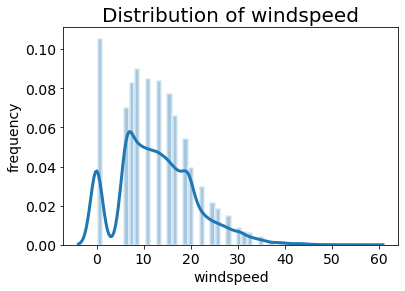

In [20]:
# histogram of a
ax = sns.distplot(bikes_df.windspeed, hist=True, hist_kws={"edgecolor": 'w', "linewidth": 3}, kde_kws={"linewidth": 3})

# notation indicating a possible outlier
ax.annotate('Possible outlier', xy=(188,0.0030), xytext=(189,0.0070), fontsize=12,
            arrowprops=dict(arrowstyle='->', ec='grey', lw=2), bbox = dict(boxstyle="round", fc="0.8"))

# ticks 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# labels and title
plt.xlabel('windspeed', fontsize=14)
plt.ylabel('frequency', fontsize=14)
plt.title('Distribution of windspeed', fontsize=20);

/Users/hannah.westberg/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of windspeed')

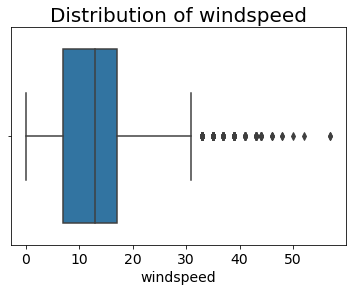

In [21]:
# box plot of the variable temp
ax = sns.boxplot(bikes_df.windspeed)

# notation indicating an outlier
ax.annotate('Outlier', xy=(190,0), xytext=(186,-0.05), fontsize=14,
            arrowprops=dict(arrowstyle='->', ec='grey', lw=2), bbox = dict(boxstyle="round", fc="0.8"))

# xtick, label, and title
plt.xticks(fontsize=14)
plt.xlabel('windspeed', fontsize=14)
plt.title('Distribution of windspeed', fontsize=20)

- quite a few outliers on windspeed- to keep or exclude?
- I'm thinking keep, as super high windspeeds would probably dissuade folks from renting bikes. 

### Count

/Users/hannah.westberg/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of count')

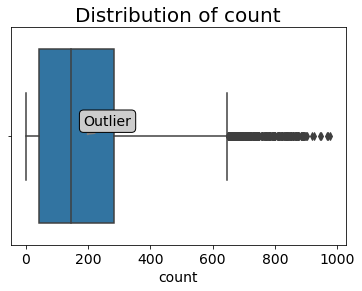

In [22]:
# box plot of the target variable-count
ax = sns.boxplot(bikes_df['count'])

# notation indicating an outlier
ax.annotate('Outlier', xy=(190,0), xytext=(186,-0.05), fontsize=14,
            arrowprops=dict(arrowstyle='->', ec='grey', lw=2), bbox = dict(boxstyle="round", fc="0.8"))

# xtick, label, and title
plt.xticks(fontsize=14)
plt.xlabel('count', fontsize=14)
plt.title('Distribution of count', fontsize=20)

- Quite a few outliers on count. I think I"ll remove them, because they could skew the mean

### Remove outliers for count 

In [23]:
upper = bikes_df['count'].mean() + 1.5*bikes_df['count'].std()

In [24]:
lower= bikes_df['count'].mean() - 1.5* bikes_df['count'].std()

In [25]:
bikes_rm_outliers = bikes_df[(bikes_df['count'] < upper) & (bikes_df['count'] > lower)]

### Check box plot again

/Users/hannah.westberg/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of count (remove outliers)')

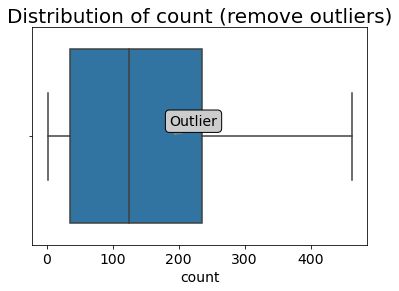

In [26]:
# box plot of the target variable-count
ax = sns.boxplot(bikes_rm_outliers['count'])

# notation indicating an outlier
ax.annotate('Outlier', xy=(190,0), xytext=(186,-0.05), fontsize=14,
            arrowprops=dict(arrowstyle='->', ec='grey', lw=2), bbox = dict(boxstyle="round", fc="0.8"))

# xtick, label, and title
plt.xticks(fontsize=14)
plt.xlabel('count', fontsize=14)
plt.title('Distribution of count (remove outliers)', fontsize=20)

- looking better now

## EDA

### Numerical Features

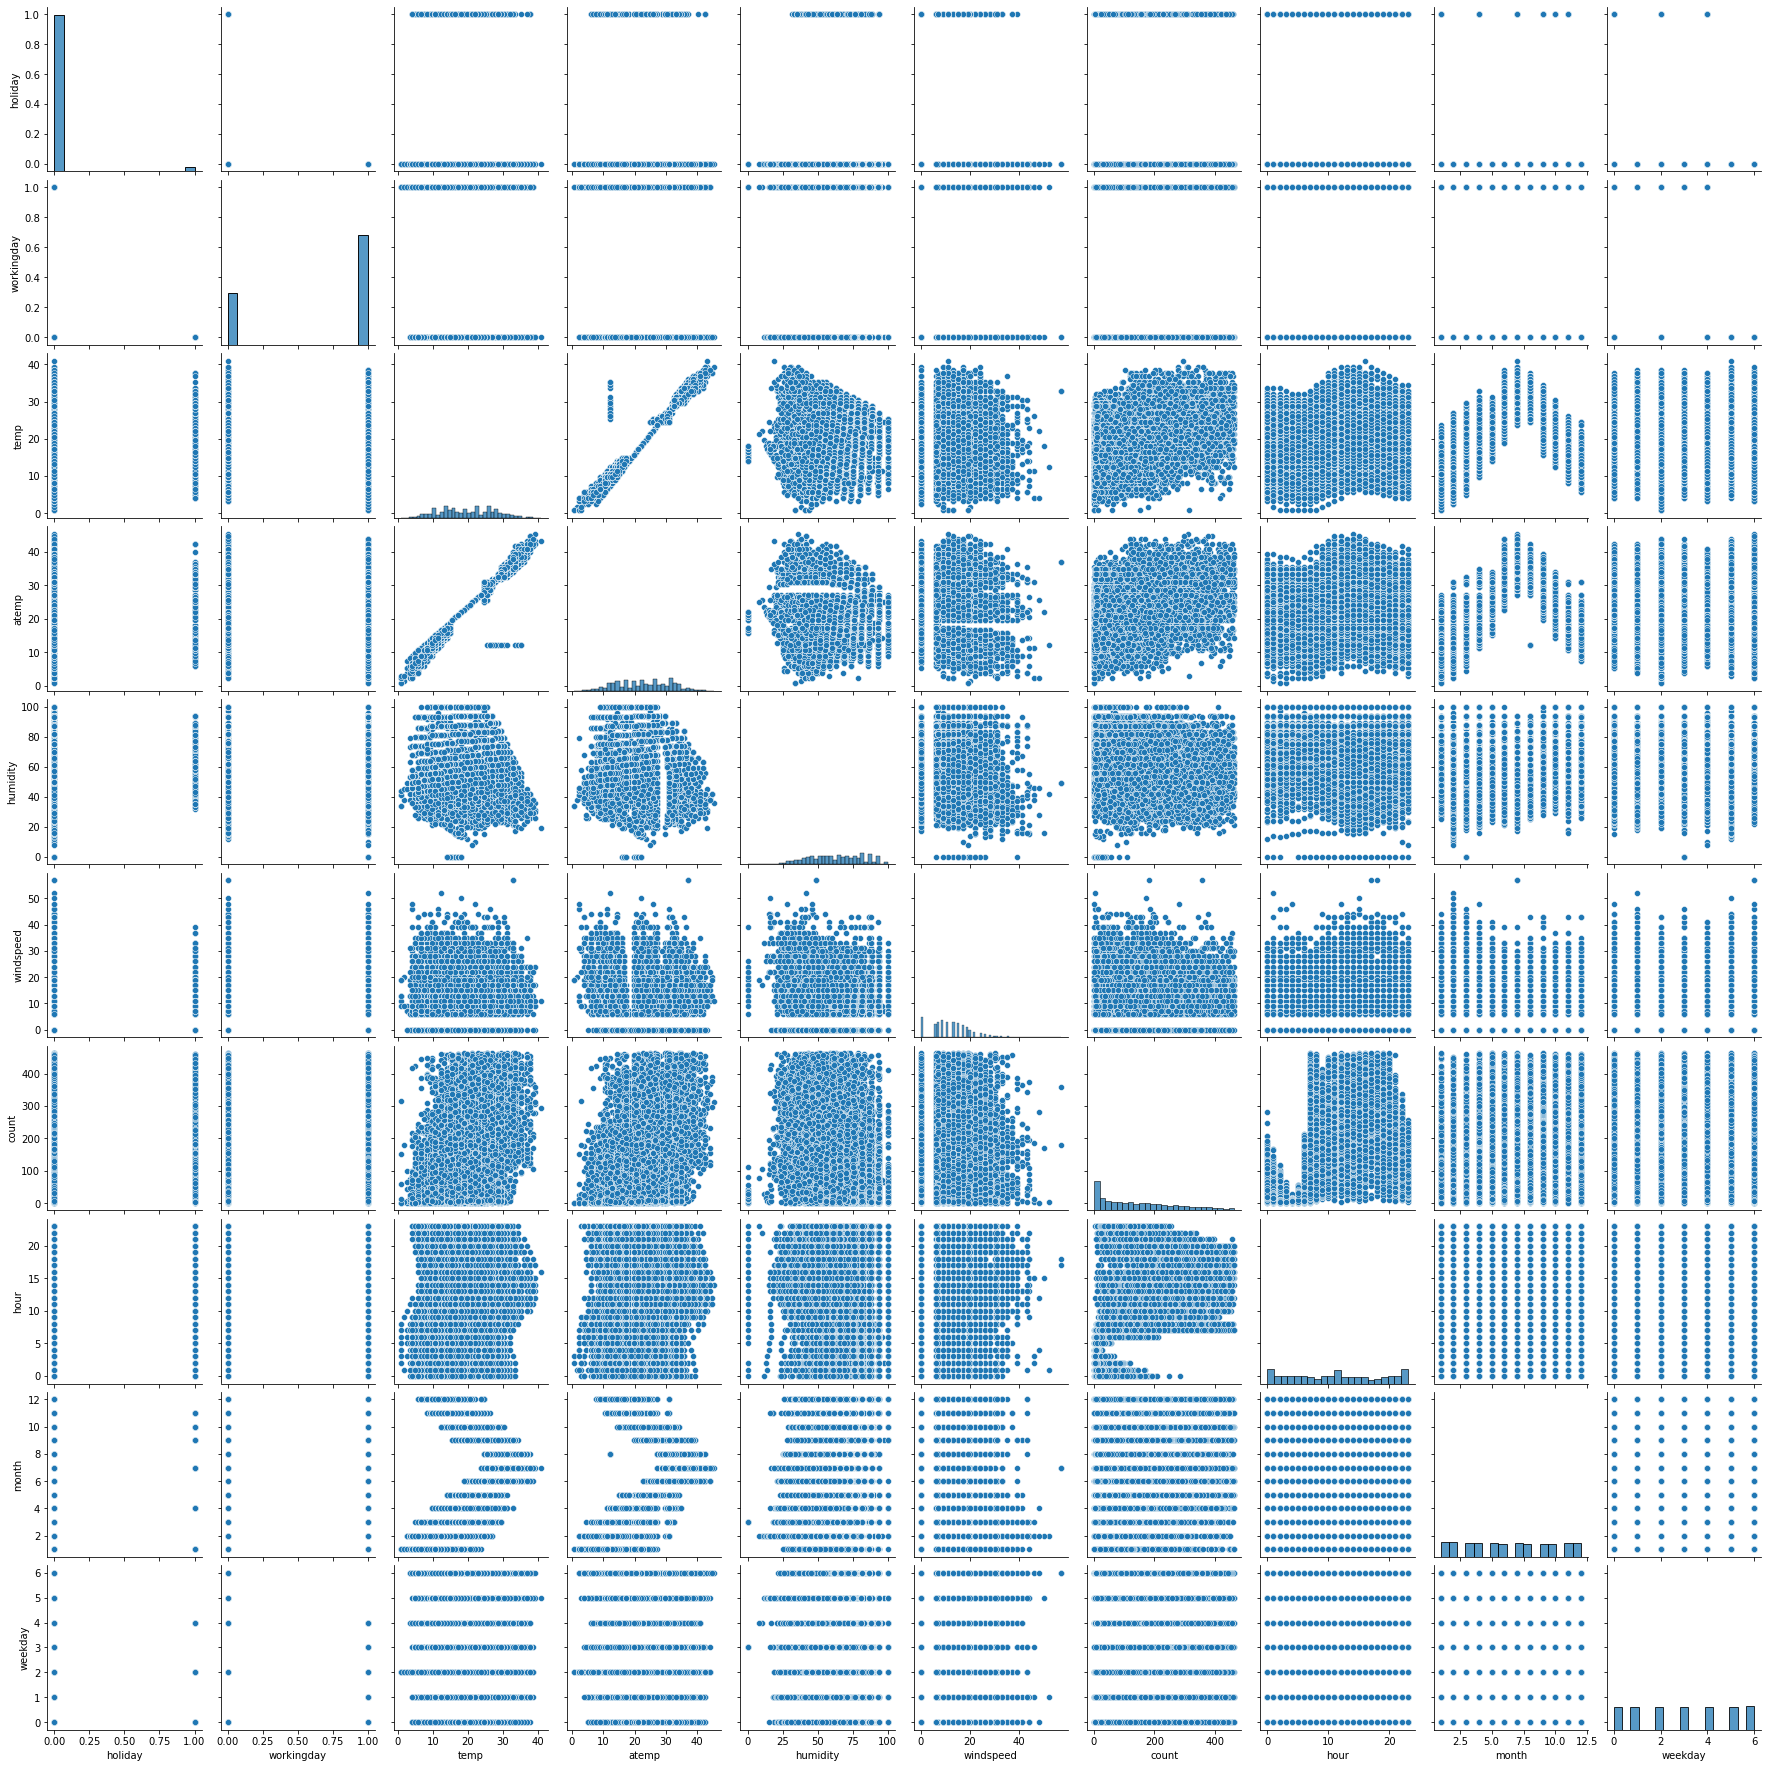

In [27]:
# pairplot
sns.pairplot(bikes_rm_outliers)

- slower windspeeds seem to have higher counts 
- lower humidity seems to have more rentals
- higher temperatures have higher counts - temp and atemp are similar, choose one
- day of week, hour, and month also seem like good variables
- not sure how to handle time of day

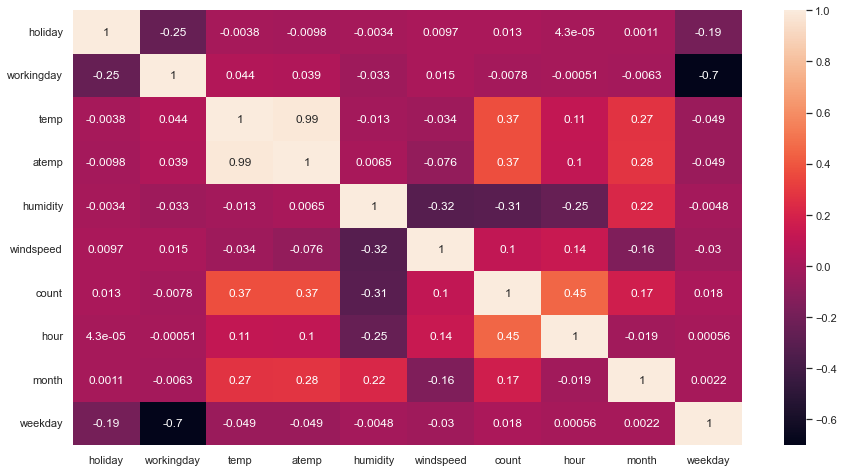

In [28]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(bikes_rm_outliers.corr(), annot=True);


- windspeed, hour, month, temp, humidity seem strongest. 
- atemp and temp seem very correlative, perhaps we just use one? Thinking atemp, since that's how it feels outside. 

<function matplotlib.pyplot.show(close=None, block=None)>

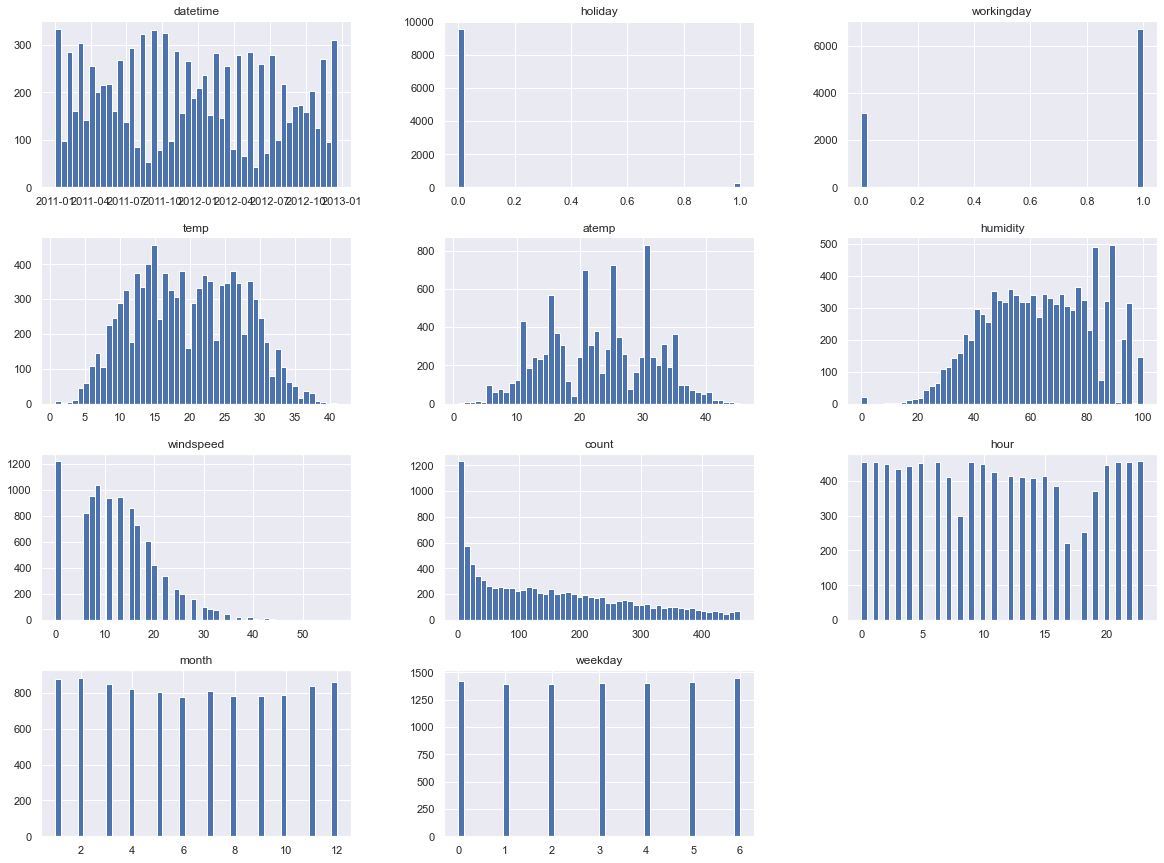

In [29]:
bikes_rm_outliers.hist(bins=50, figsize=(20,15));
plt.show

- holiday is very underrepresented- this might be a variable to remove eventually

### Categorical Variables

In [30]:
## create function to return a bar plot for catgorical features:

def plot_cat_bar(groupby_col):

    df = bikes_rm_outliers.groupby(groupby_col)[['count']].mean()

    df = df.reset_index()

    df.rename(columns={'count':'mean_count'})
    
    ax = sns.barplot(x=groupby_col,y='count',data=df, palette='hls');
    
    ax.set(xlabel=groupby_col,ylabel='Avg Count',title="Avg count by %s." % groupby_col);
           
    return  ax


        

### Seasons

In [31]:
bikes_rm_outliers['season'].value_counts()

Spring    2608
Winter    2489
Summer    2402
Fall      2374
Name: season, dtype: int64

<AxesSubplot:title={'center':'Avg count by season.'}, xlabel='season', ylabel='Avg Count'>

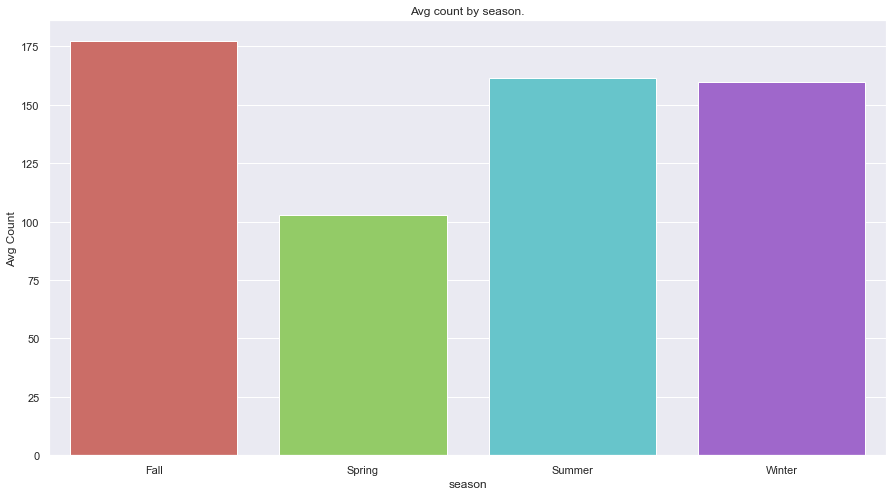

In [32]:
plot_cat_bar('season')

- Season has an effect on rentals - looks like higher in the Fall and Summer, lowest in the Spring, medium in the winter. 

### Weather

In [33]:
bikes_rm_outliers['weather'].value_counts()

Clear Skies          6409
Partly Cloudy        2632
Light Storms/Rain     831
Heavy Storms/Rain       1
Name: weather, dtype: int64

- only one day with Heavy Storms/Rain - let's drop this

In [34]:
 bikes_rm_outliers = bikes_rm_outliers[bikes_rm_outliers['weather'] != 'Heavy Storms/Rain']

<AxesSubplot:title={'center':'Avg count by weather.'}, xlabel='weather', ylabel='Avg Count'>

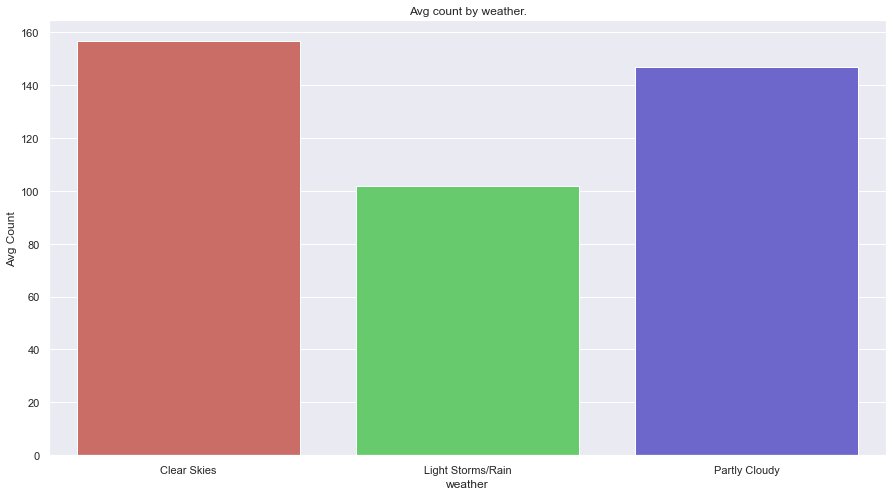

In [35]:
plot_cat_bar('weather')


- Weather also seems to influence rentals - Clear Skies and Partlye Cloudy have higher average rentals than Light Storms/Rain

### holiday

In [36]:
bikes_rm_outliers['holiday'].value_counts()

0    9583
1     289
Name: holiday, dtype: int64

<AxesSubplot:title={'center':'Avg count by holiday.'}, xlabel='holiday', ylabel='Avg Count'>

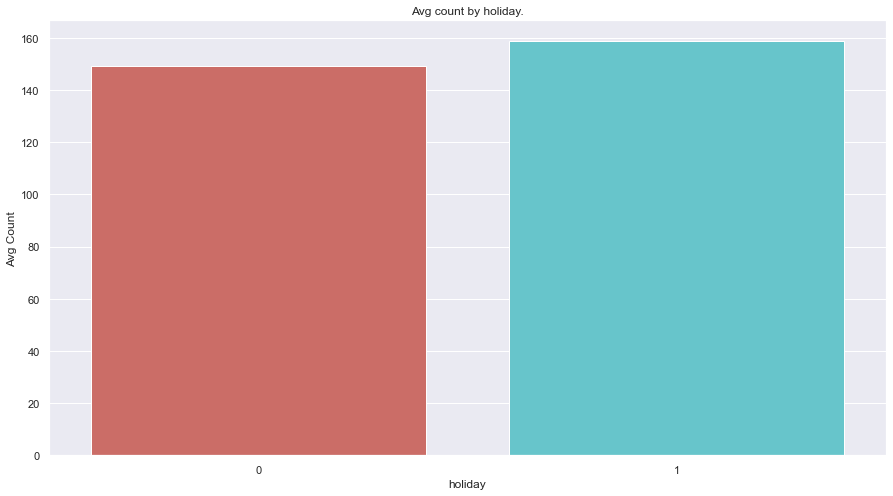

In [37]:
plot_cat_bar('holiday')


- lower count of holidays- should we use this feature?
- also doesn't seem to predictive... I think we should exclude it

### workingday

In [38]:
bikes_rm_outliers['workingday'].value_counts()

1    6716
0    3156
Name: workingday, dtype: int64

<AxesSubplot:title={'center':'Avg count by workingday.'}, xlabel='workingday', ylabel='Avg Count'>

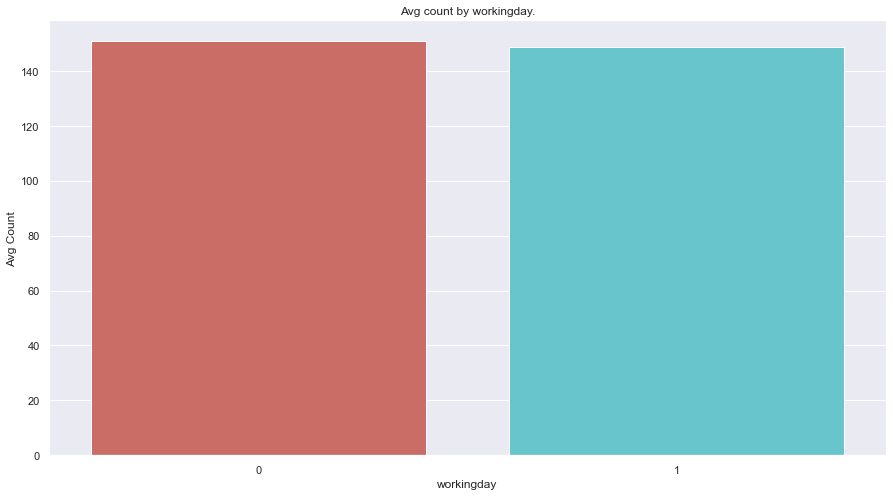

In [39]:
plot_cat_bar('workingday')

- doesn't seem to be very predictive

### month

In [40]:
bikes_rm_outliers['month'].value_counts()

2     883
1     876
12    861
3     848
11    838
4     822
7     810
5     805
10    790
8     783
9     781
6     775
Name: month, dtype: int64

<AxesSubplot:title={'center':'Avg count by month.'}, xlabel='month', ylabel='Avg Count'>

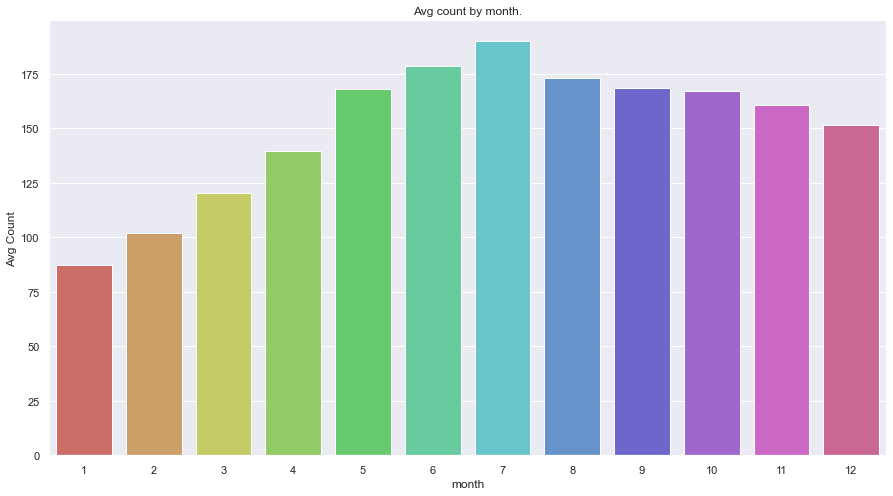

In [41]:
plot_cat_bar('month')

- Month seems very predictive - rentals increase during the summer and decrease during the winter months. 

### hour

In [42]:
bikes_rm_outliers['hour'].value_counts()

23    456
6     455
22    455
21    455
9     455
0     455
1     454
5     452
10    449
2     448
20    445
4     442
3     433
11    427
12    415
15    414
7     412
13    410
14    409
16    385
19    372
8     299
18    253
17    222
Name: hour, dtype: int64

<AxesSubplot:title={'center':'Avg count by hour.'}, xlabel='hour', ylabel='Avg Count'>

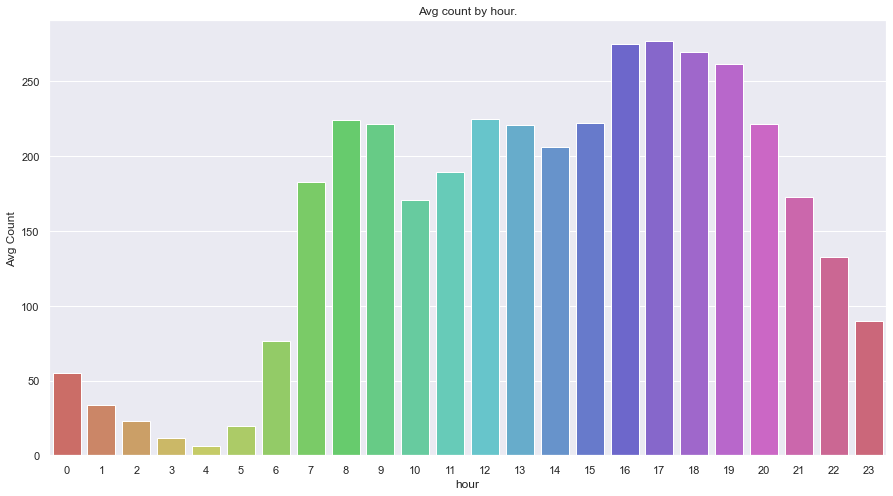

In [43]:
plot_cat_bar('hour')

- Hour is very predictive! definitely include this feature.

### weekday

In [44]:
bikes_rm_outliers['weekday'].value_counts()

6    1451
0    1419
5    1416
4    1402
3    1401
1    1392
2    1391
Name: weekday, dtype: int64

<AxesSubplot:title={'center':'Avg count by weekday.'}, xlabel='weekday', ylabel='Avg Count'>

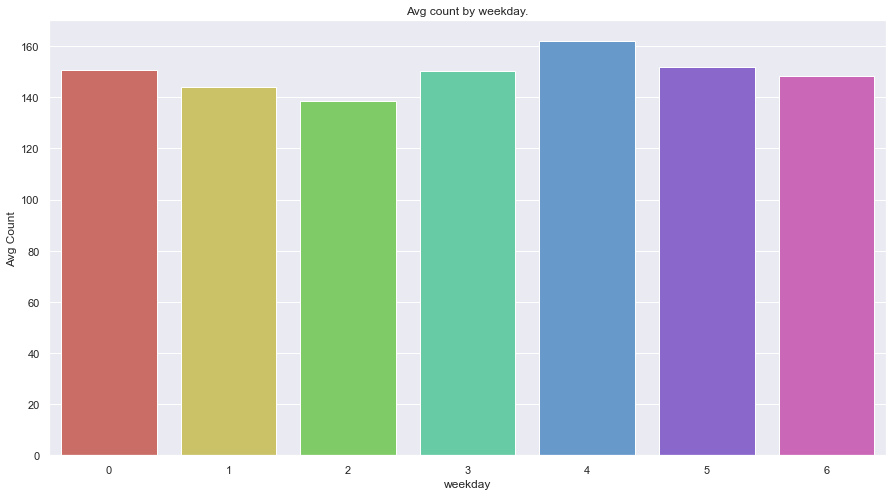

In [45]:
plot_cat_bar('weekday')

- weekday seems like a weaker variable, but might still be worth including

### time of day

In [46]:
bikes_rm_outliers['hour'].value_counts()

23    456
6     455
22    455
21    455
9     455
0     455
1     454
5     452
10    449
2     448
20    445
4     442
3     433
11    427
12    415
15    414
7     412
13    410
14    409
16    385
19    372
8     299
18    253
17    222
Name: hour, dtype: int64

<AxesSubplot:title={'center':'Avg count by hour.'}, xlabel='hour', ylabel='Avg Count'>

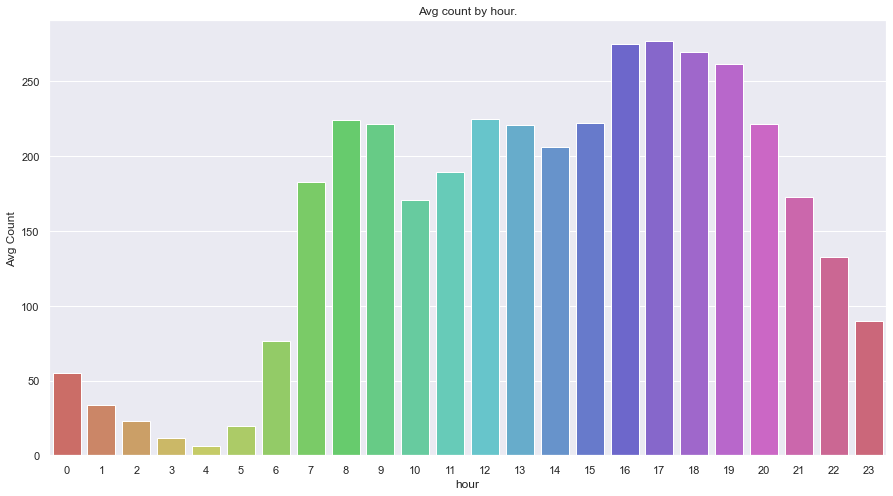

In [47]:
plot_cat_bar('hour')

- hour is really strong- more rentals during commuting hours

In [48]:
bikes_rm_outliers.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,time,hour,month,weekday
0,2011-01-01 00:00:00,Spring,0,0,Clear Skies,9.84,14.395,81,0.0,16,00:00:00,0,1,5
1,2011-01-01 01:00:00,Spring,0,0,Clear Skies,9.02,13.635,80,0.0,40,01:00:00,1,1,5
2,2011-01-01 02:00:00,Spring,0,0,Clear Skies,9.02,13.635,80,0.0,32,02:00:00,2,1,5
3,2011-01-01 03:00:00,Spring,0,0,Clear Skies,9.84,14.395,75,0.0,13,03:00:00,3,1,5
4,2011-01-01 04:00:00,Spring,0,0,Clear Skies,9.84,14.395,75,0.0,1,04:00:00,4,1,5


### Final Feature list:
- season
- weather
- month
- hour
- atemp
- humidity
- windspeed
- weekday


Notes: 

- excluding holiday - imbalanced and didn't seem predictive
- excluding workday- didn't seem predictive and is probably captured in weekday
- just using atemp, since temp and atemp were correlated.


### Assign Variables


In [49]:
X= bikes_rm_outliers[[ 'season', 'weather', 'month', 'hour', 'atemp', 'humidity', 'windspeed', 'weekday']]


In [50]:
y=bikes_rm_outliers['count']

### Train Test Split

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [53]:
# examine training set
X_train

,season,weather,month,hour,atemp,humidity,windspeed,weekday
9957,Winter,Light Storms/Rain,10,6,25.760,94,11.0014,4
9494,Fall,Partly Cloudy,9,23,26.515,83,15.0013,1
1955,Summer,Clear Skies,5,9,26.515,52,15.0013,6
4017,Fall,Clear Skies,9,10,24.240,72,11.0014,6
2328,Summer,Clear Skies,6,22,31.060,57,15.0013,5
...,...,...,...,...,...,...,...,...
5903,Spring,Light Storms/Rain,2,4,20.455,82,6.0032,3
5349,Winter,Partly Cloudy,12,23,15.150,49,8.9981,4
5548,Spring,Partly Cloudy,1,7,14.395,65,0.0000,4
860,Spring,Clear Skies,2,7,19.695,17,35.0008,5


In [54]:
#examine test set
X_test

,season,weather,month,hour,atemp,humidity,windspeed,weekday
8971,Fall,Clear Skies,8,4,29.545,73,15.0013,3
7851,Summer,Clear Skies,6,12,31.820,42,0.0000,3
6346,Spring,Clear Skies,3,16,27.275,32,19.9995,3
7244,Summer,Partly Cloudy,5,5,25.000,72,6.0032,1
7559,Summer,Light Storms/Rain,5,8,25.760,88,15.0013,0
...,...,...,...,...,...,...,...,...
10382,Winter,Partly Cloudy,11,0,15.150,70,11.0014,6
2961,Fall,Clear Skies,7,7,34.850,55,12.9980,1
5864,Spring,Clear Skies,1,13,10.605,47,19.0012,3
8340,Fall,Clear Skies,7,21,36.365,70,8.9981,6


In [55]:
y_train

9957    131
9494     78
1955    160
4017    260
2328    190
       ... 
5903      1
5349     75
5548    205
860      22
7671    148
Name: count, Length: 7404, dtype: int64

In [56]:
y_test

8971       5
7851     336
6346     361
7244      17
7559     156
        ... 
10382    129
2961     330
5864     124
8340     207
4863     451
Name: count, Length: 2468, dtype: int64

## Encode Variables 
- season
- weather
- fit & transform on training data
- only transform on test data

In [57]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

In [58]:
smart_encoder = make_column_transformer((OneHotEncoder(drop = 'if_binary'), ['season', 'weather']), remainder='passthrough'
                       )                        
                        

In [59]:
X_train_encoded = smart_encoder.fit_transform(X_train)
X_test_encoded = smart_encoder.transform(X_test)

### Examine encoded X_train and X_test encoded to see if it makes sense

In [60]:
X_train_encoded = pd.DataFrame(X_train_encoded, columns=smart_encoder.get_feature_names())

In [61]:
X_train_encoded.head()

,onehotencoder__x0_Fall,onehotencoder__x0_Spring,onehotencoder__x0_Summer,onehotencoder__x0_Winter,onehotencoder__x1_Clear Skies,onehotencoder__x1_Light Storms/Rain,onehotencoder__x1_Partly Cloudy,month,hour,atemp,humidity,windspeed,weekday
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,10.0,6.0,25.760,94.0,11.0014,4.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,9.0,23.0,26.515,83.0,15.0013,1.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,5.0,9.0,26.515,52.0,15.0013,6.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,9.0,10.0,24.240,72.0,11.0014,6.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,6.0,22.0,31.060,57.0,15.0013,5.0


In [62]:
X_test_encoded = pd.DataFrame(X_test_encoded, columns=smart_encoder.get_feature_names())

In [63]:
X_test_encoded

,onehotencoder__x0_Fall,onehotencoder__x0_Spring,onehotencoder__x0_Summer,onehotencoder__x0_Winter,onehotencoder__x1_Clear Skies,onehotencoder__x1_Light Storms/Rain,onehotencoder__x1_Partly Cloudy,month,hour,atemp,humidity,windspeed,weekday
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0,4.0,29.545,73.0,15.0013,3.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,6.0,12.0,31.820,42.0,0.0000,3.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,16.0,27.275,32.0,19.9995,3.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,5.0,5.0,25.000,72.0,6.0032,1.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,5.0,8.0,25.760,88.0,15.0013,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463,0.0,0.0,0.0,1.0,0.0,0.0,1.0,11.0,0.0,15.150,70.0,11.0014,6.0
2464,1.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0,7.0,34.850,55.0,12.9980,1.0
2465,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,13.0,10.605,47.0,19.0012,3.0
2466,1.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0,21.0,36.365,70.0,8.9981,6.0


## Linear Regression

### Instantiate the Model

In [64]:
lr = LinearRegression()

In [65]:
lr.fit(X_train_encoded, y_train)

LinearRegression()

In [66]:
lr.coef_

array([-24.49256527,  14.30153659,   6.62870411,   3.56232458,
         1.75095541, -15.63956901,  13.8886136 ,   6.39440163,
         6.28184426,   5.50296546,  -1.60334761,   0.32163831,
         1.88100543])

In [67]:
lr.intercept_

-1.8139109590118778

### Score the model

In [68]:
lr.score(X_train_encoded, y_train)

0.38713819874620314

Make predictions on the test set, using X_test_encoded

In [69]:
test_preds = lr.predict(X_test_encoded)

In [70]:
train_preds= lr.predict(X_train_encoded)

In [71]:
mean_squared_error(y_train, train_preds) 

9682.13948653462

In [72]:
mean_squared_error(y_test, test_preds)

9422.758103219634

- higher mean squared error on train set than test set- this is abnormal... does it mean we're over fitting?
- this also seems really high? 
- does this mean on average we were off by 9k rentals in our predictions? - no if I look at the sqrt of this then that would mean on avg my bike model is off by X amount


In [73]:
cross_val_score(lr, X_train_encoded, y_train, cv=5, scoring='neg_mean_squared_error').mean()

-9728.94085545449

In [78]:
# on avg my model is off by 98 bikes per day 
np.sqrt(9728)

98.63062404750362

- kind of lost on how to evaluate this model

## Polynomial Features

In [86]:
# create the transformer
poly_features = PolynomialFeatures(degree=2, include_bias=False)

# apply it to our data sets and store as variable
X_train_quad = poly_features.fit_transform(X_train_encoded)
X_test_quad = poly_features.transform(X_test_encoded)

In [85]:
# cross validate the polynomial model and compare to earlier
cross_val_score(lr, X_train_quad, y_train, scoring='neg_mean_squared_error').mean()
# this estimator doesn't actually fit this instance, it just evalueates it, so you still need to fit the model

-7152.66689489777

- this is a lower MSE, but is it better?

In [87]:
lr.fit(X_train_quad, y_train)

LinearRegression()

In [88]:
### don't understand why this is giving me an error 
test_preds = lr.predict(X_train_quad)

In [89]:
test_preds

array([ 88.48661041, 171.24881744, 240.32872772, ..., 116.77069092,
       129.36563873,  17.00994873])

In [90]:
# how to compare to actuals? can import other metrics here to eval the predictions
from sklearn.metrics import mean_squared_error

mean_squared_error(y_train, test_preds)

7013.572552926983

In [93]:
np.sqrt(mean_squared_error(y_train, test_preds))
# on avg, this model is off by about 83 bike rentals

83.74707489176552

### Scale Features
- Features are of different magnitudes, so it might help to scale them?

In [ ]:
sscaler = StandardScaler()
X_train_scaled = sscaler.fit_transform(X_train_encoded)
X_test_scaled =sscaler.transform(X_test_encoded)

In [ ]:
X_train_scaled

In [ ]:
X_test_scaled

In [ ]:
cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error').mean()

In [ ]:
cross_val_score(lr, X_test_scaled, y_test, cv=5, scoring='neg_mean_squared_error').mean()

In [ ]:
test_preds = lr.predict(X_test_scaled)

In [ ]:
test_preds[:10]

- why are there negative predictions?

In [ ]:
y_test[:10]

### Conclusion:
- The polynomial model seemed to perform best
- Althought I'm still getting lost in how to evaluate models and how to tune them
- I hope we can review this a bit more in class??